In [3]:
import torch; torch.manual_seed(100)
import math

import numpy as np
import torch.distributions
import torch.nn as nn
import torch.utils
import torchvision
from torchvision import datasets, transforms

np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from collections import Counter, OrderedDict

import pytorch_lightning as pl
import scanpy as sc
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pandas as pd

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [32]:
# download the data
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
# load data as anndata object
PBMC_train = sc.read_h5ad("../data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

c:\Users\adamb\miniconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
PBMC_train.obs.columns

Index(['GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors',
       'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts',
       'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order',
       'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality',
       'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker',
       'is_train'],
      dtype='object')

In [5]:
print(PBMC_train) #the data is stored as an anndata object
print(Counter(PBMC_train.obs["cell_type"])) #summary of cell types

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
Counter({'CD14+ Mono': 21693, 'CD4+ T activated': 6966, 'CD4+ T naive': 5897, 'NK': 5434, 'Reticulocyte': 4272, 'Erythroblast': 4039, 'Naive CD20+ B IGKC+': 3990, 'CD8+ T naive': 3107, 'CD16+ Mono': 2635, 'NK CD158e1+': 2167, 'Naive CD20+ B IGKC-': 1979, 'G/M prog': 1881, 'pDC': 1758, 'HSC': 1703, 'cDC2': 1702, 'Lymph prog': 1681, 'Transition

In [28]:
class Exp(nn.Module):
    """Applies torch.exp, clamped to improve stability during training"""

    def __init__(self, minimum=1e-5, maximum=1e6):
        """Values taken from DCA"""
        super(Exp, self).__init__()
        self.min_value = minimum
        self.max_value = maximum

    def forward(self, input):
        return torch.clamp(
            torch.exp(input),
            min=self.min_value,
            max=self.max_value,
        )


class ClippedSoftplus(nn.Module):
    def __init__(self, beta=1, threshold=20, minimum=1e-4, maximum=1e3):
        super(ClippedSoftplus, self).__init__()
        self.beta = beta
        self.threshold = threshold
        self.min_value = minimum
        self.max_value = maximum

    def forward(self, input):
        return torch.clamp(
            F.softplus(input, self.beta, self.threshold),
            min=self.min_value,
            max=self.max_value,
        )

    def extra_repr(self):
        return "beta={}, threshold={}, min={}, max={}".format(
            self.beta,
            self.threshold,
            self.min_value,
            self.max_value,
        )



def negative_binom_loss(preds, theta, truth, scale_factor: float = 1.0, eps: float = 1e-10, mean: bool = True, debug=True):
    """Calculates negative binomial loss as defined in the NB class in link above"""
    y_true = truth
    y_pred = preds * scale_factor

    if debug:  # Sanity check before loss calculation
        assert not torch.isnan(y_pred).any(), y_pred
        assert not torch.isinf(y_pred).any(), y_pred
        assert not (y_pred < 0).any()  # should be non-negative
        assert not (theta < 0).any()

    # Clip theta values
    theta = torch.clamp(theta, max=1e6)

    t1 = (
        torch.lgamma(theta + eps)
        + torch.lgamma(y_true + 1.0)
        - torch.lgamma(y_true + theta + eps)
    )
    t2 = (theta + y_true) * torch.log1p(y_pred / (theta + eps)) + (
        y_true * (torch.log(theta + eps) - torch.log(y_pred + eps))
    )
    if debug:  # Sanity check after calculating loss
        assert not torch.isnan(t1).any(), t1
        assert not torch.isinf(t1).any(), (t1, torch.sum(torch.isinf(t1)))
        assert not torch.isnan(t2).any(), t2
        assert not torch.isinf(t2).any(), t2

    retval = t1 + t2
    if debug:
        assert not torch.isnan(retval).any(), retval
        assert not torch.isinf(retval).any(), retval

    return torch.mean(retval) if mean else retval

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     )  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(hidden_dims, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(hidden_dims, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.mu(x)) # exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z


In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, input_dims),
                                     
                                     )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded

In [9]:
# class VariationalAutoencoder(nn.Module):
#     def __init__(self, latent_dims, input_dims, hidden_dims, dropout = 0.3, z_dropout=0.3):
#         super(VariationalAutoencoder, self).__init__()
#         self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
#         self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

In [10]:
# Variational Autoencoder definition
class VariationalAutoencoder(pl.LightningModule):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout=0.3, z_dropout=0.3, learning_rate=1e-3, beta = 0.001):
        super(VariationalAutoencoder, self).__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)
        self.learning_rate = learning_rate
        self.beta = beta

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        x = batch
        x = x.view(x.size(0), -1)
        x_reconstructed = self(x)
        kld = self.beta * self.encoder.kl
        recon_loss = F.mse_loss(x_reconstructed, x, reduction='mean')
        loss = recon_loss + kld
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recon_loss', recon_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_kld', kld, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch
        x = x.view(x.size(0), -1)
        x_reconstructed = self(x)
        kld = self.beta * self.encoder.kl
        recon_loss = F.mse_loss(x_reconstructed, x, reduction='mean')
        loss = recon_loss + kld
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_recon_loss', recon_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_kld', kld, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x = batch
        x = x.view(x.size(0), -1)
        x_reconstructed = self(x)
        kld = self.beta * self.encoder.kl
        recon_loss = F.mse_loss(x_reconstructed, x, reduction='mean')
        loss = recon_loss + kld
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_recon_loss', recon_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_kld', kld, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [11]:
PBMC_train.var["feature_types"]

AL627309.5    GEX
LINC01409     GEX
LINC01128     GEX
LINC00115     GEX
FAM41C        GEX
             ... 
HLA-E         ADT
CD82          ADT
CD101         ADT
CD88          ADT
CD224         ADT
Name: feature_types, Length: 14087, dtype: category
Categories (2, object): ['ADT', 'GEX']

In [33]:
ADT_mask = PBMC_train.var["feature_types"] == "ADT"
GEX_mask = PBMC_train.var["feature_types"] == "GEX"

ADT_anndata = PBMC_train[:, ADT_mask]

sc.pp.normalize_total(ADT_anndata)
# ADT_data = PBMC_train.X[:, ADT_mask]
# GEX_data = PBMC_train.X[:, GEX_mask]

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


MemoryError: Unable to allocate 38.7 MiB for an array with shape (10141612,) and data type int32

In [46]:
sc.tl.pca(ADT_anndata, svd_solver='arpack')

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


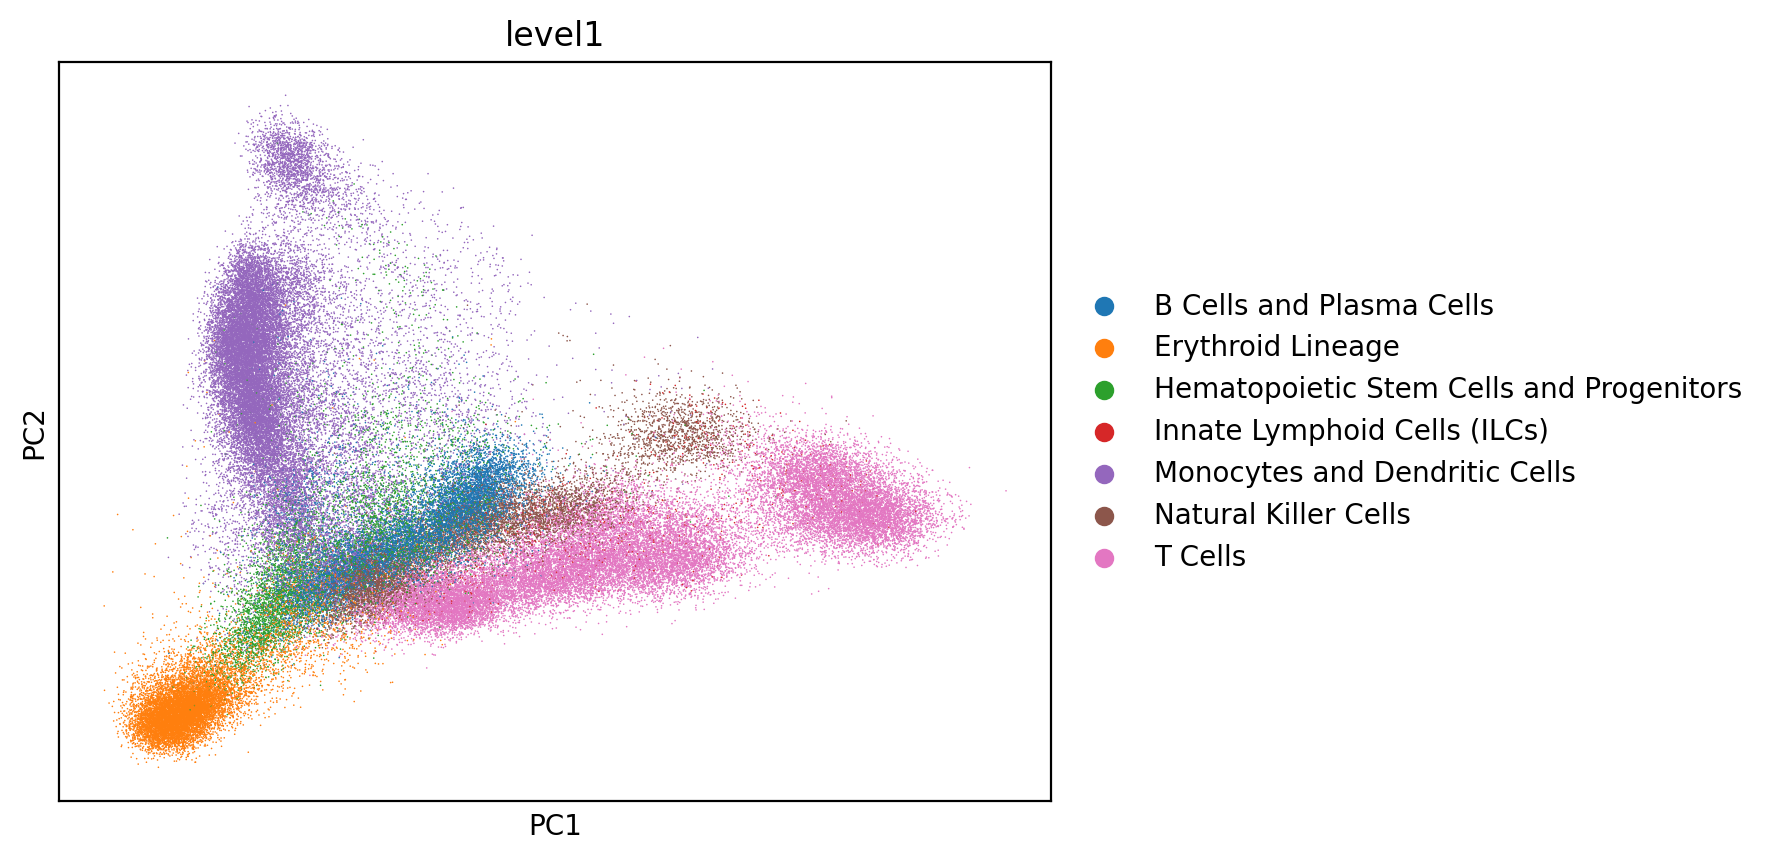

In [48]:
sc.pl.pca(ADT_anndata, color='level1')

In [ ]:
plt.hist(ADT_anndata.X.A[:, 100])

In [34]:
def normalize_data(data):
    data = np.log1p(data)
    
    # std = np.std(data, axis=0)
    # mean = np.mean(data, axis=0)
    
    # data = (data - mean) / std
    
    return data

In [50]:
# Hyperparameters
input_dims = ADT_anndata.shape[1]
latent_dims = 20
hidden_dims = 50
batch_size = 128
dropout = 0.1
z_dropout = 0.1
learning_rate = 1e-3
max_epochs = 10
beta = 0.01

# Data

data = normalize_data(ADT_anndata.X.A)

ADT_data_train, ADT_data_val = random_split(data, [0.9, 0.1])
train_loader = DataLoader(ADT_data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ADT_data_val, batch_size=batch_size)

# Model
model = VariationalAutoencoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout, learning_rate, beta)

# Trainer
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(model, train_loader, val_loader)
# trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 13.9 K
1 | decoder | Decoder | 10.4 K
------------------------------------
24.3 K    Trainable params
0         Non-trainable params
24.3 K    Total params
0.097     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [54]:
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 13.9 K
1 | decoder | Decoder | 10.4 K
------------------------------------
24.3 K    Trainable params
0         Non-trainable params
24.3 K    Total params
0.097     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [102]:
checkpoint_pat = "lightning_logs/version_25/checkpoints/epoch=9-step=12700.ckpt"
model = VariationalAutoencoder.load_from_checkpoint(checkpoint_pat, latent_dims=latent_dims, hidden_dims=hidden_dims, input_dims=input_dims, dropout=dropout, z_dropout=z_dropout, learning_rate=learning_rate, beta=beta)

In [51]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.A).to(device)
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

In [52]:
ADT_anndata.obsm["latent_embedding"] = to_latent(model, ADT_anndata)

In [105]:
ADT_anndata

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'latent_embedding'
    layers: 'counts'

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


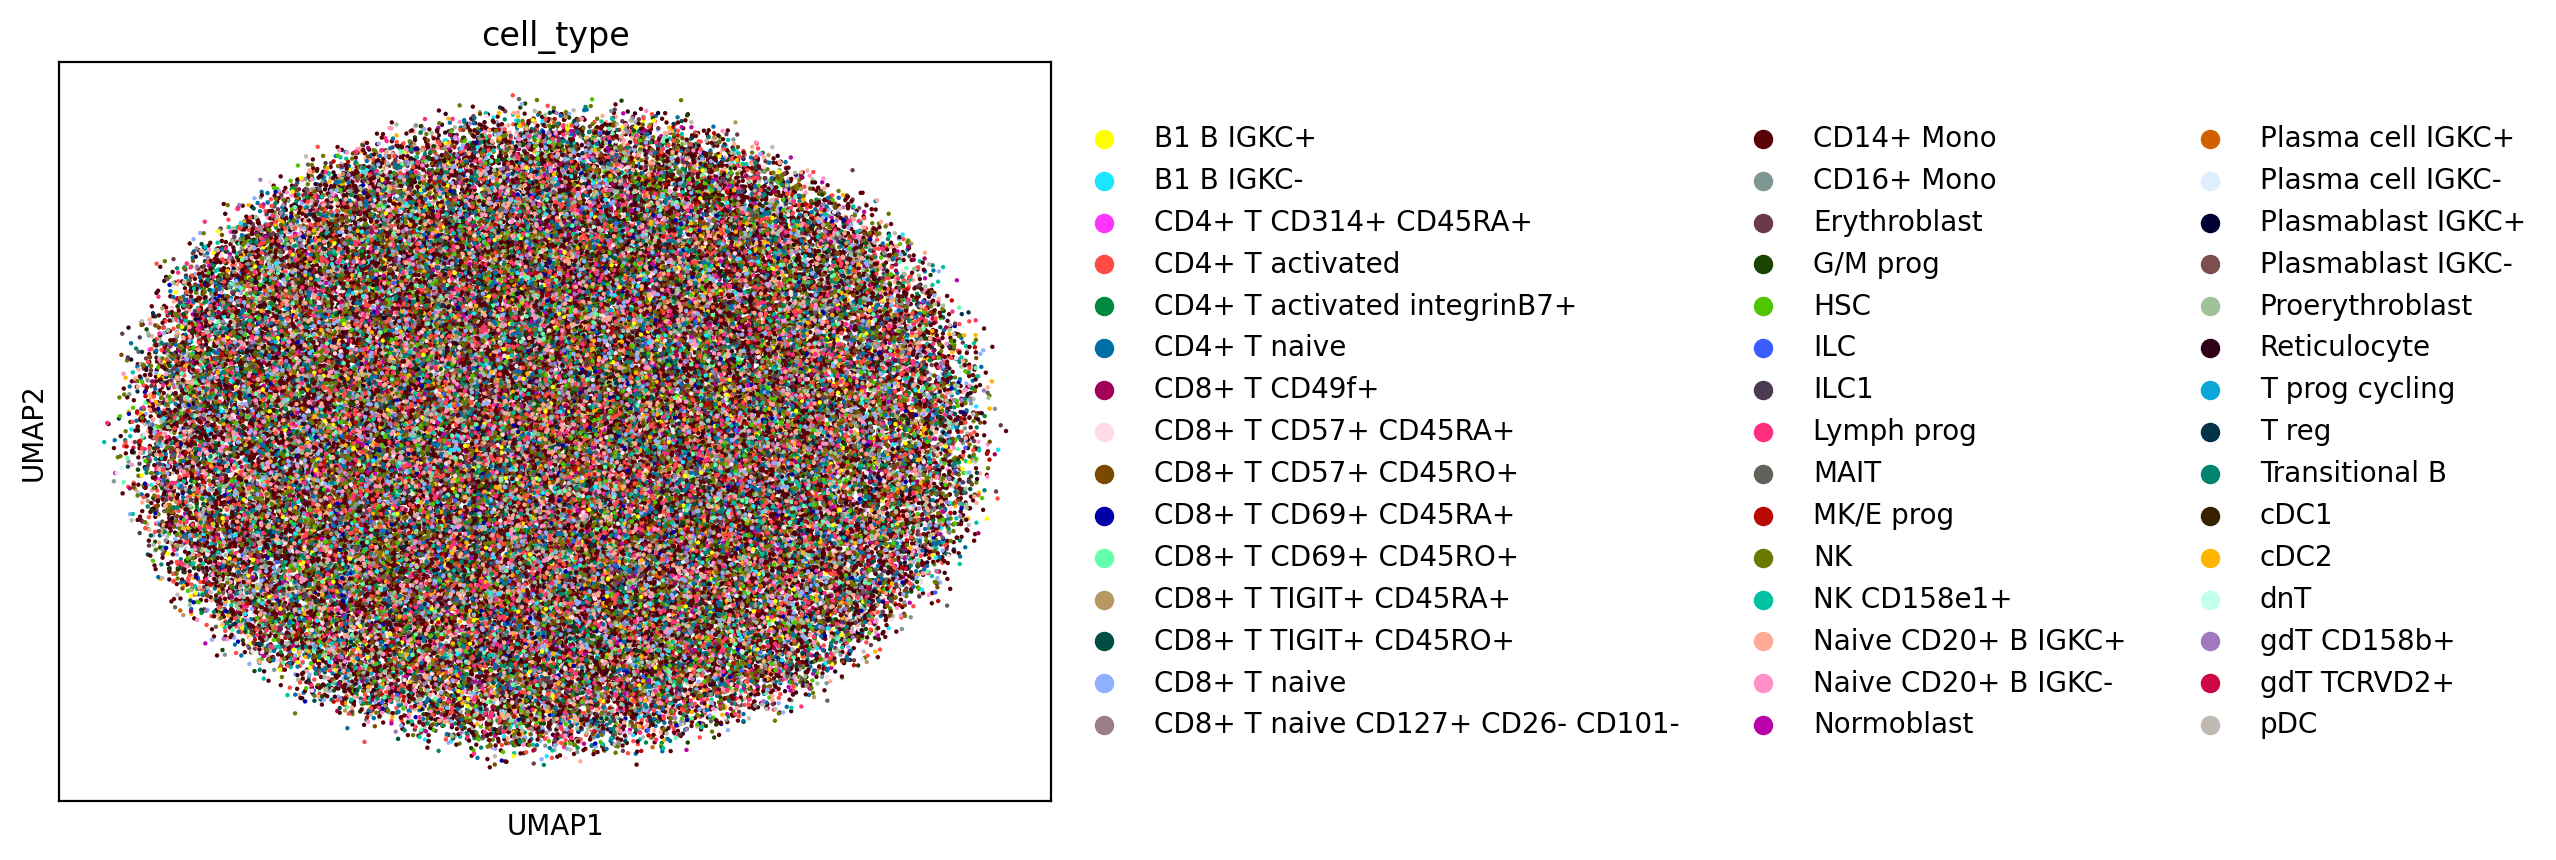

In [53]:
sc.pp.neighbors(ADT_anndata, use_rep='latent_embedding', n_neighbors=15) # use_rep specifies that the calculation is based on the latent embedding
sc.tl.umap(ADT_anndata, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(ADT_anndata, color=["cell_type"], size=10, ncols = 1)

In [54]:
hierarchy = {'level1': ['Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Hematopoietic Stem Cells and Progenitors', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'Monocytes and Dendritic Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'T Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'B Cells and Plasma Cells', 'Natural Killer Cells', 'Natural Killer Cells', 'Erythroid Lineage', 'Erythroid Lineage', 'Erythroid Lineage', 'Erythroid Lineage', 'Innate Lymphoid Cells (ILCs)', 'Innate Lymphoid Cells (ILCs)'], 'level2': ['HSC', 'Progenitors', 'Progenitors', 'Progenitors', 'Monocytes', 'Monocytes', 'Dendritic Cells', 'Dendritic Cells', 'Dendritic Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'CD8+ T Cells', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Special T Cell Types', 'Naive B Cells', 'Naive B Cells', 'Transitional B Cells', 'B1 B Cells', 'B1 B Cells', 'Plasma Cells', 'Plasma Cells', 'Plasmablasts', 'Plasmablasts', 'NK', 'NK CD158e1+', 'Erythroblasts and Precursors', 'Erythroblasts and Precursors', 'Erythroblasts and Precursors', 'Reticulocytes', 'ILC', 'ILC1'], 'level3': ['HSC', 'Lymph prog', 'G/M prog', 'MK/E prog', 'CD14+ Mono', 'CD16+ Mono', 'cDC1', 'cDC2', 'pDC', 'CD4+ T naive', 'CD4+ T activated', 'CD4+ T activated integrinB7+', 'CD4+ T CD314+ CD45RA+', 'CD8+ T naive', 'CD8+ T CD57+ CD45RO+', 'CD8+ T CD57+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T TIGIT+ CD45RA+', 'CD8+ T CD49f+', 'CD8+ T CD69+ CD45RO+', 'CD8+ T CD69+ CD45RA+', 'CD8+ T naive CD127+ CD26- CD101-', 'MAIT', 'gdT CD158b+', 'gdT TCRVD2+', 'dnT', 'T reg', 'T prog cycling', 'Naive CD20+ B IGKC+', 'Naive CD20+ B IGKC-', 'Transitional B', 'B1 B IGKC+', 'B1 B IGKC-', 'Plasma cell IGKC+', 'Plasma cell IGKC-', 'Plasmablast IGKC+', 'Plasmablast IGKC-', 'NK', 'NK CD158e1+', 'Proerythroblast', 'Erythroblast', 'Normoblast', 'Reticulocyte', 'ILC', 'ILC1'], 'description': ['Hematopoietic Stem Cells', 'Lymphoid progenitors', 'Granulocyte-Macrophage progenitors', 'Megakaryocyte-Erythroid progenitors', 'CD14+ Monocytes', 'CD16+ Monocytes', 'Conventional Dendritic Cells, subtype 1', 'Conventional Dendritic Cells, subtype 2', 'Plasmacytoid Dendritic Cells', 'Naive CD4+ T Cells', 'Activated CD4+ T Cells', 'Activated CD4+ T Cells expressing integrin β7', 'CD4+ T Cells expressing CD314 and CD45RA', 'Naive CD8+ T Cells', 'CD8+ T Cells expressing CD57 and CD45RO', 'CD8+ T Cells expressing CD57 and CD45RA', 'CD8+ T Cells expressing TIGIT and CD45RO', 'CD8+ T Cells expressing TIGIT and CD45RA', 'CD8+ T Cells expressing CD49f', 'CD8+ T Cells expressing CD69 and CD45RO', 'CD8+ T Cells expressing CD69 and CD45RA', 'Naive CD8+ T Cells expressing CD127, not CD26 or CD101', 'Mucosal-Associated Invariant T Cells', 'Gamma Delta T Cells expressing CD158b', 'Gamma Delta T Cells expressing TCRVδ2', 'Double-Negative T Cells', 'Regulatory T Cells', 'Cycling Progenitor T Cells', 'Naive B Cells expressing CD20 and IGKC', 'Naive B Cells expressing CD20, not IGKC', 'Transitional B Cells', 'B1 B Cells expressing IGKC', 'B1 B Cells not expressing IGKC', 'Plasma Cells expressing IGKC', 'Plasma Cells not expressing IGKC', 'Plasmablasts expressing IGKC', 'Plasmablasts not expressing IGKC', 'Natural Killer Cells', 'Natural Killer Cells expressing CD158e1', 'Proerythroblast', 'Erythroblast', 'Normoblast', 'Reticulocyte', 'Innate Lymphoid Cells', 'ILC1']}
hierarchy_df = pd.DataFrame(data = hierarchy)
ADT_anndata.obs = pd.merge(ADT_anndata.obs, hierarchy_df, left_on="cell_type", right_on="level3", how="left")

In [56]:
ADT_anndata.obs.columns

Index(['GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors',
       'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts',
       'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order',
       'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality',
       'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker',
       'is_train', 'level1_x', 'level2_x', 'level3_x', 'description_x',
       'level1_y', 'level2_y', 'level3_y', 'description_y'],
      dtype='object')

In [30]:
ADT_anndata.obs["level1"].value_counts()

level1
Monocytes and Dendritic Cells               27806
T Cells                                     26985
Erythroid Lineage                           11258
B Cells and Plasma Cells                     9866
Natural Killer Cells                         7601
Hematopoietic Stem Cells and Progenitors     5955
Innate Lymphoid Cells (ILCs)                  790
Name: count, dtype: int64

c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\adamb\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


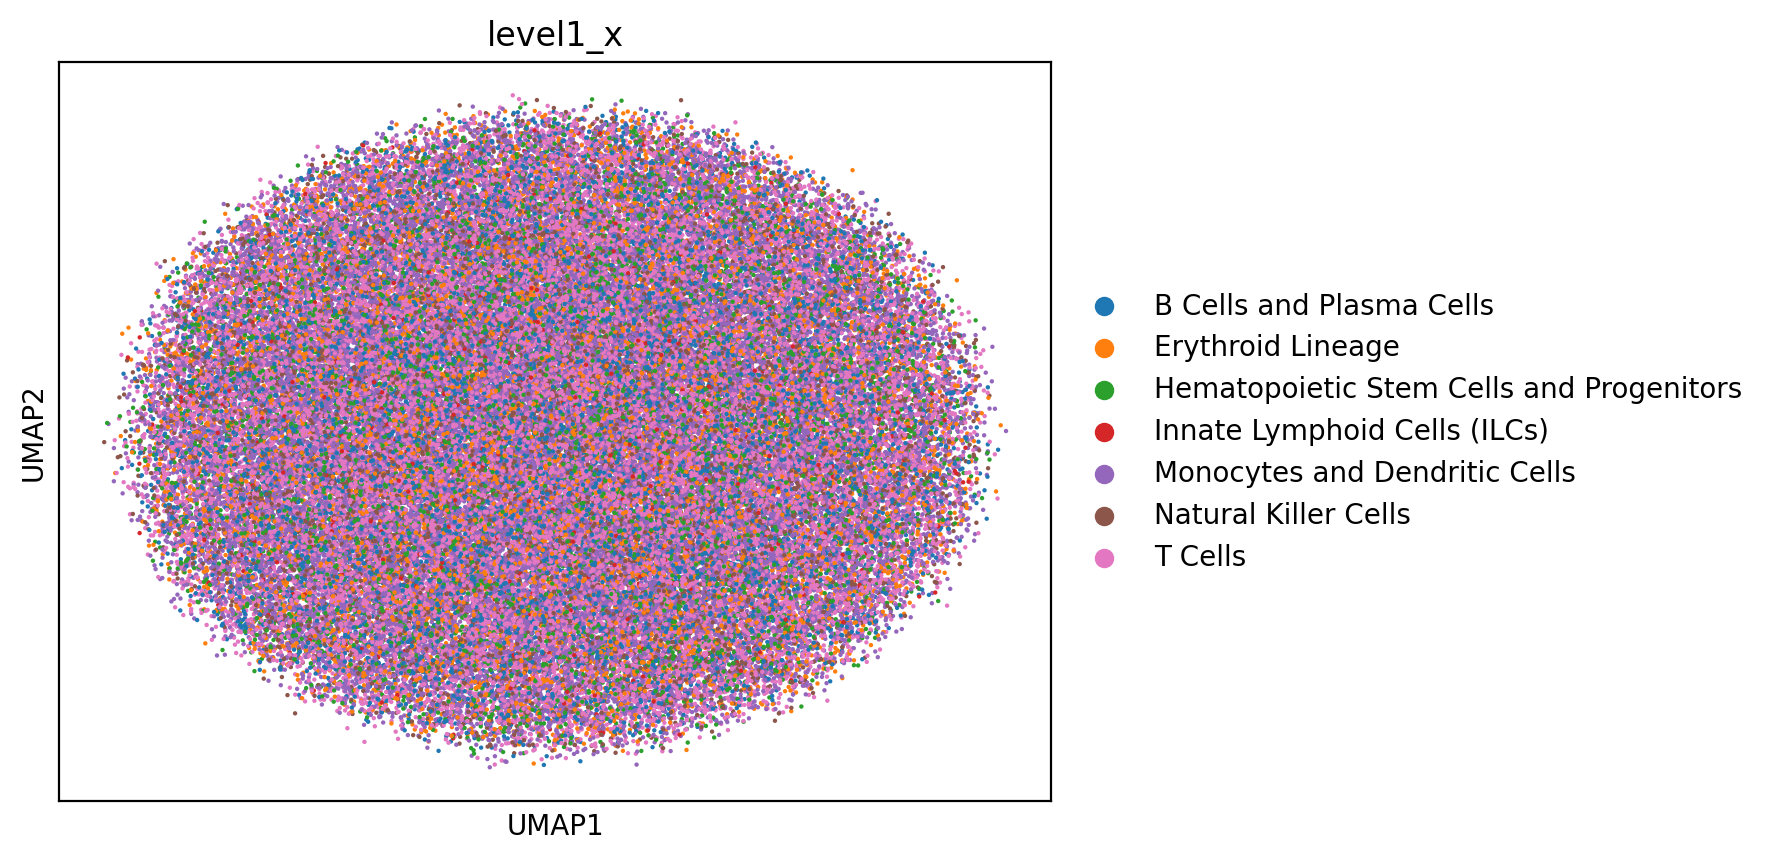

In [57]:
sc.pp.neighbors(ADT_anndata, use_rep='latent_embedding', n_neighbors=15) # use_rep specifies that the calculation is based on the latent embedding
sc.tl.umap(ADT_anndata, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(ADT_anndata, color=["level1_x"], size=10, ncols = 1)

pd

In [115]:
ADT_anndata.obsm['X_pca_latent'].shape

(90261, 2)

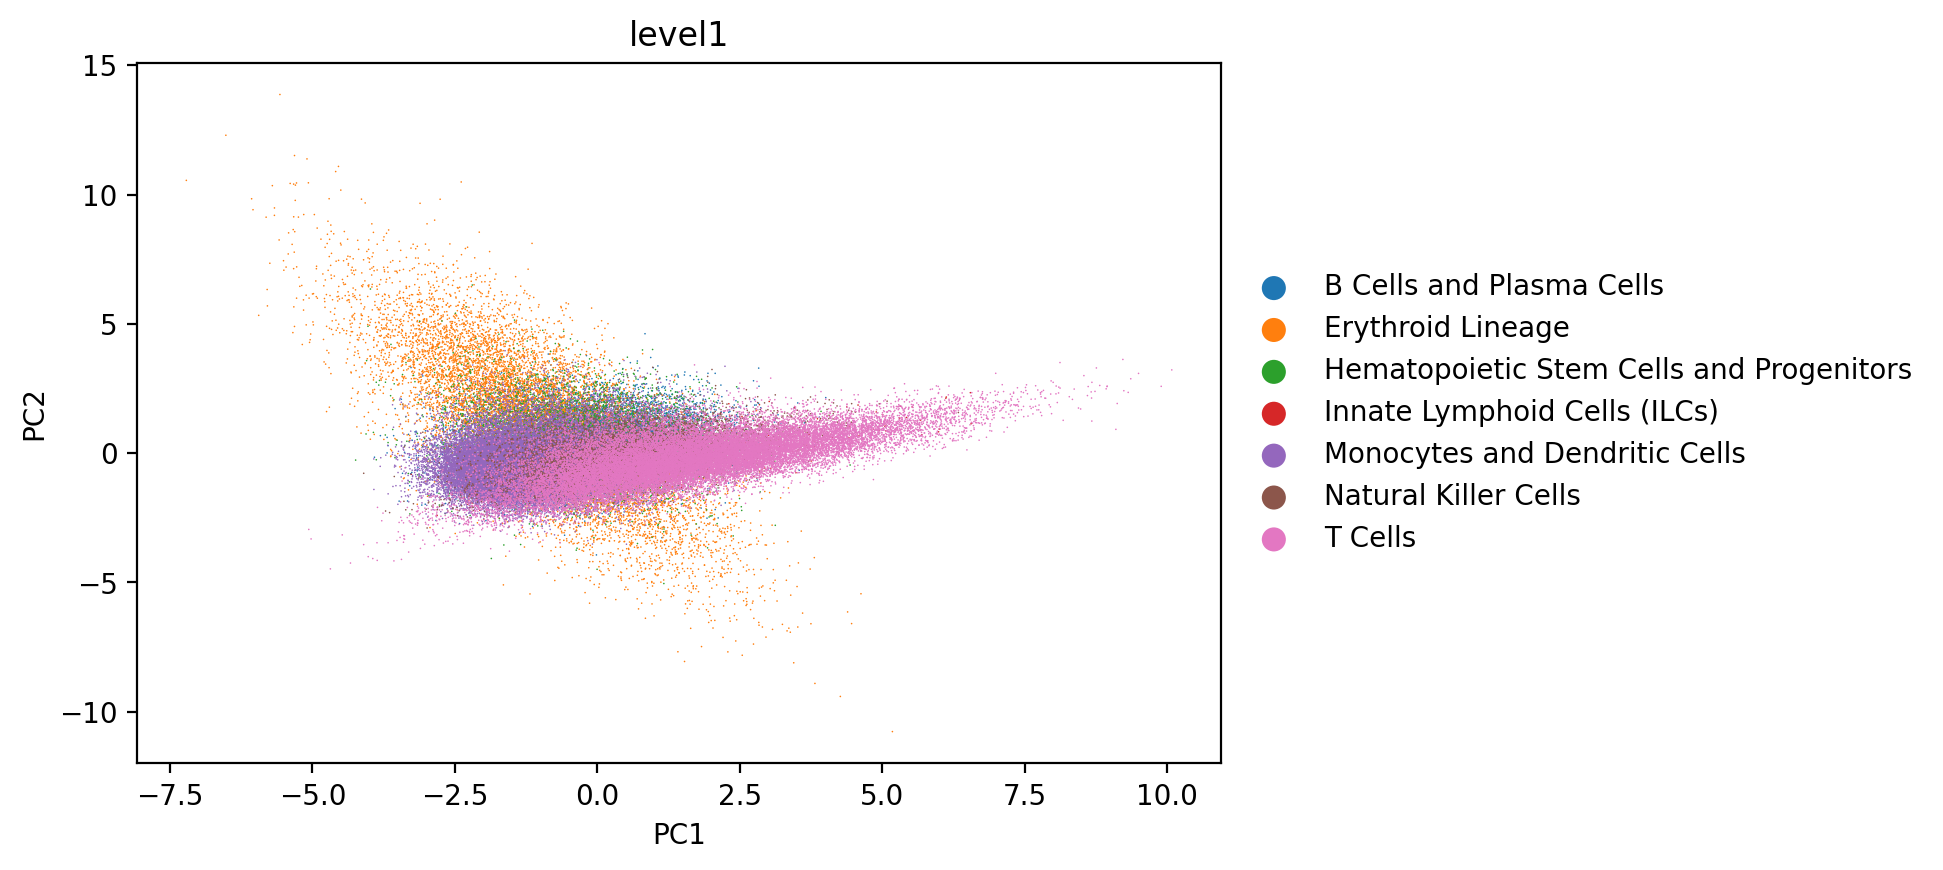

In [ ]:
import scanpy as sc
from sklearn.decomposition import PCA

# Extract the latent embedding
latent_embedding = ADT_anndata.obsm['latent_embedding']

# Perform PCA on the latent embedding
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_embedding)

# Store the PCA results back in the AnnData object
ADT_anndata.obsm['X_pca_latent'] = latent_pca
ADT_anndata.uns['pca_latent_variance_ratio'] = pca.explained_variance_ratio_

# Create a new AnnData object for visualization purposes
pca_anndata = sc.AnnData(X=latent_pca)
pca_anndata.obs = ADT_anndata.obs
pca_anndata.var_names = [f"PC{i+1}" for i in range(latent_pca.shape[1])]

# Visualize the PCA results
sc.pl.scatter(pca_anndata, x="PC1", y="PC2", color='level1')


In [42]:
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Define the MLP model using PyTorch Lightning
class MLPClassifier(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = self.criterion(output, target)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)



In [39]:
data = normalize_data(ADT_anndata.X.A)

In [ ]:
data = ADT_anndata.obsm['latent_embedding']

In [40]:
# Extract the labels (cell types)
labels = ADT_anndata.obs['level1'].values

# Encode labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert to PyTorch tensors
X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(labels_encoded, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
input_dim = data.shape[1]
hidden_dim = 64
output_dim = len(np.unique(labels_encoded))

model = MLPClassifier(input_dim, hidden_dim, output_dim)

# Define a trainer
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model/',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)
trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint_callback])

# Train the model
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\adamb\Documents\Projects\D4L-Hackaton\notebooks\my_model exists and is not empty.

  | Name      | Type             | Params
-----------------------------------------------
0 | fc1       | Linear           | 8.6 K 
1 | fc2       | Linear           | 4.2 K 
2 | fc3       | Linear           | 455   
3 | relu      | ReLU             | 0     
4 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [44]:
# Loading the best model for evaluation
best_model_path = checkpoint_callback.best_model_path
best_model = MLPClassifier.load_from_checkpoint(best_model_path, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Evaluate the model on test set
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.40%


## 2nd Modality

In [14]:
GEX_anndata = PBMC_train[:, GEX_mask]

sc.pp.normalize_total(GEX_anndata)

In [15]:
# Hyperparameters
input_dims = GEX_anndata.shape[1]
latent_dims = 20
hidden_dims = 50
batch_size = 64
dropout = 0.1
z_dropout = 0.1
learning_rate = 1e-3
max_epochs = 10
beta = 0.0001

# Data

data = normalize_data(GEX_anndata.X.A)

GEX_data_train, GEX_data_val = random_split(data, [0.9, 0.1])
train_loader = DataLoader(GEX_data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(GEX_data_val, batch_size=batch_size)

# Model
model = VariationalAutoencoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout, learning_rate, beta)

# Trainer
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(model, train_loader, val_loader)
# trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [16]:
data = normalize_data(GEX_anndata.X.A)

In [17]:
GEX_data_train, GEX_data_val = random_split(data, [0.9, 0.1])
train_loader = DataLoader(GEX_data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(GEX_data_val, batch_size=batch_size)

In [18]:
# Model
model = VariationalAutoencoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout, learning_rate, beta)

# Trainer
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(model, train_loader, val_loader)
# trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 704 K 
1 | decoder | Decoder | 715 K 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.680     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\adamb\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
input_dim = latent_embedding.shape[1]
hidden_dim = 64
output_dim = len(np.unique(labels_encoded))

model = MLPClassifier(input_dim, hidden_dim, output_dim)

# Define a trainer
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model/',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)
trainer = pl.Trainer(max_epochs=10, callbacks=[checkpoint_callback])

# Train the model
trainer.fit(model, train_loader, test_loader)

AnnData object with n_obs × n_vars = 90261 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [25]:
del PBMC_train

In [26]:
GEX_anndata.obsm["latent_embedding"] = to_latent(model, GEX_anndata)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5037646932 bytes.